### FD Fast Sweeping Method for benchmark


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable



### Domain and Model Parameters
- Defines the spatial domain dimensions (2x2km), grid resolution, and source location (1km, 1km)
- Velocity model parameters 2.0km/s at the surface with constant gradient of 0.5s^-1
- Creates coordinate grids for the 2D seismic modeling domain
- Converts the continuous source coordinates to discrete grid indices

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (FSM runs on CPU)
device = torch.device("cpu")
print(f"Using device: {device}")

# Domain parameters
x_min, x_max = 0.0, 2.0  # km
z_min, z_max = 0.0, 2.0  # km
dx, dz = 0.02, 0.02  # km (20m)
nx, nz = 101, 101  # grid points
source_x, source_z = 1.0, 1.0  # km

# Velocity model parameters
v0 = 2.0  # km/s at surface
vertgrad = 0.5  # s^{-1}
horigrad = 0.0

# Generate grid coordinates
x = torch.linspace(x_min, x_max, nx, device=device)
z = torch.linspace(z_min, z_max, nz, device=device)
X, Z = torch.meshgrid(x, z, indexing='ij')
coords = torch.stack((X.flatten(), Z.flatten()), dim=1)

# Velocity model (vertically varying)
v_ref = v0 + vertgrad * source_z + horigrad * source_x
velmodel = v_ref + vertgrad * (X - source_x) + horigrad * (Z - source_z)

# Analytical traveltime solution
if vertgrad == 0 and horigrad == 0:
    T_data = torch.sqrt((Z - source_z)**2 + (X - source_x)**2) / v0
else:
    T_data = torch.arccosh(
        1.0 + 0.5 * (1.0 / velmodel) * (1 / v_ref) * (vertgrad**2 + horigrad**2) * 
        ((X - source_x)**2 + (Z - source_z)**2)
    ) / torch.sqrt(torch.tensor(vertgrad**2 + horigrad**2))

# Convert velocity model to NumPy for FSM
velmodel_np = velmodel.cpu().numpy()

# Find source indices
x_grid = np.linspace(x_min, x_max, nx)
z_grid = np.linspace(z_min, z_max, nz)
i_source = np.argmin(np.abs(x_grid - source_x))
j_source = np.argmin(np.abs(z_grid - source_z))

Using device: cpu


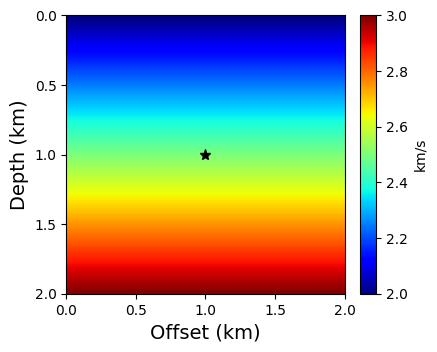

In [3]:
# Plot the velocity model with the source location
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel_np, extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")

ax.plot(source_x, source_z,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

### Fast Sweeping Method (FSM) Implementation
- Implements the FSM algorithm for solving the Eikonal equation
- The iterative solver computes seismic traveltimes through the velocity model using alternating sweep directions to handle multiple wave propagation paths

In [4]:
# FSM Implementation
def fsm_solver(velocity, dx, dz, source_idx, max_iters=50):
    nx, nz = velocity.shape
    T = np.full((nx, nz), 1e10)  # Initialize with large values
    i_src, j_src = source_idx
    T[i_src, j_src] = 0.0  # Set source point
    
    # Precompute coefficients
    dx2, dz2 = dx**2, dz**2
    inv_dx2, inv_dz2 = 1.0 / dx2, 1.0 / dz2
    
    # Alternating sweep directions
    sweep_dirs = [
        (range(0, nx), range(0, nz)),      # Left->Right, Top->Bottom
        (range(0, nx), range(nz-1, -1, -1)), # Left->Right, Bottom->Top
        (range(nx-1, -1, -1), range(0, nz)), # Right->Left, Top->Bottom
        (range(nx-1, -1, -1), range(nz-1, -1, -1)) # Right->Left, Bottom->Top
    ]
    
    for _ in range(max_iters):
        for i_range, j_range in sweep_dirs:
            for i in i_range:
                for j in j_range:
                    if (i, j) == (i_src, j_src):
                        continue
                    
                    # Get neighbor values (handling boundaries)
                    neighbors = []
                    if i > 0: neighbors.append(T[i-1, j])
                    if i < nx-1: neighbors.append(T[i+1, j])
                    if j > 0: neighbors.append(T[i, j-1])
                    if j < nz-1: neighbors.append(T[i, j+1])
                    
                    if not neighbors:
                        continue
                    
                    # Sort neighbors to find smallest two
                    neighbors_sorted = np.sort(neighbors)
                    T1 = neighbors_sorted[0]
                    T2 = neighbors_sorted[1] if len(neighbors) > 1 else T1
                    
                    # Coefficients for quadratic equation
                    a = inv_dx2 + inv_dz2
                    b = -2 * (T1 * inv_dx2 + T2 * inv_dz2)
                    c = (T1**2 * inv_dx2 + T2**2 * inv_dz2) - 1.0 / (velocity[i, j]**2)
                    
                    discriminant = b**2 - 4 * a * c
                    
                    if discriminant >= 0:
                        root = (-b + np.sqrt(discriminant)) / (2 * a)
                        # Check if root is greater than the neighbors
                        if root > max(T1, T2):
                            T_new = root
                        else:
                            T_new = T1 + dx / velocity[i, j]
                    else:
                        T_new = T1 + dx / velocity[i, j]
                    
                    # Update if new value is smaller
                    if T_new < T[i, j]:
                        T[i, j] = T_new
    return T

# Compute FSM solution
source_idx = (i_source, j_source)
T_fsm = fsm_solver(velmodel_np, dx, dz, source_idx)

In [5]:
# Convert analytical solution to NumPy
T_data_np = T_data.cpu().numpy()


### Results Visualization
- This plots (1) the velocity model, (2) FSM-computed traveltimes, and (3) analytical traveltimes
- `np.save` saves the FSM results as a NumPy file for comparison in other analyses - PIELM and PINNs

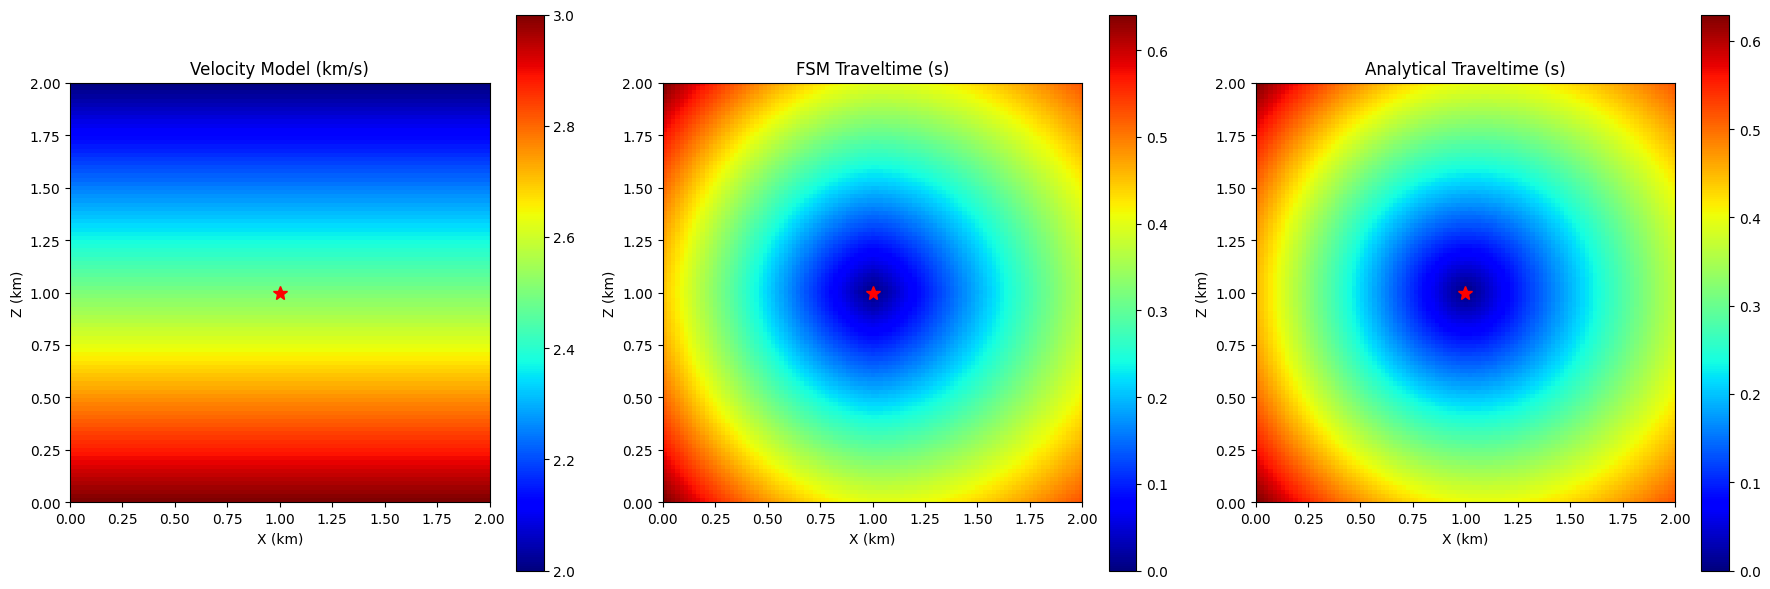

In [6]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Velocity model
vel_plot = axes[0].imshow(velmodel_np, origin='upper', 
                   extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[0].plot(source_x, source_z, 'r*', markersize=10)
axes[0].set_title("Velocity Model (km/s)")
plt.colorbar(vel_plot, ax=axes[0])

# FSM traveltime
travel_plot = axes[1].imshow(T_fsm.T, origin='lower', 
                     extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[1].plot(source_x, source_z, 'r*', markersize=10)
axes[1].set_title("FSM Traveltime (s)")
plt.colorbar(travel_plot, ax=axes[1])

# Export FSM traveltime as .npy file
np.save("Tcomp.npy", np.array(T_fsm.T))

# Analytical traveltime
ref_plot = axes[2].imshow(T_data_np.T, origin='lower', 
                  extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[2].plot(source_x, source_z, 'r*', markersize=10)
axes[2].set_title("Analytical Traveltime (s)")
plt.colorbar(ref_plot, ax=axes[2])

# Add axis labels
for ax in axes:
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Z (km)")
    ax.grid(False)

plt.tight_layout()
plt.savefig("fsm_results.png")
plt.show()

### Error Analysis
Computes and visualizes the absolute difference between FSM and analytical traveltime solutions

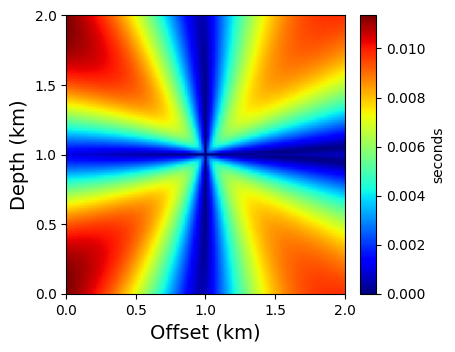

In [7]:
# Error analysis
error_fsm = np.abs(T_fsm - T_data_np)

# Plot FSM error
plt.figure(figsize=(4, 4))
ax = plt.gca()
im = ax.imshow(
    error_fsm.T, 
    origin='lower', 
    extent=[x_min, x_max, z_min, z_max],
    aspect=1, 
    cmap="jet"
)
plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('seconds', size=10)

plt.savefig("fsm_error.png", dpi=600, format='png', bbox_inches="tight")
plt.show()


### Seismic wavefront isochrones for FSM and Analytical solutions

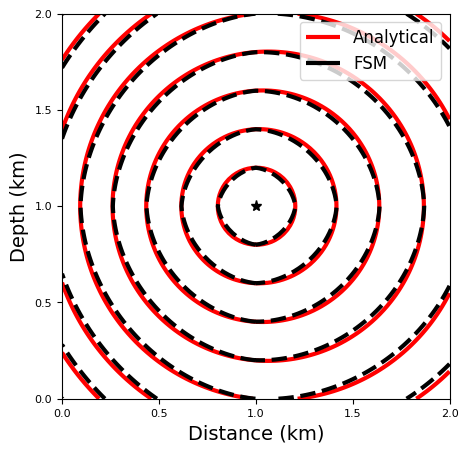

In [8]:
# Contour comparison
plt.figure(figsize=(5, 5))
ax = plt.gca()
im1 = ax.contour(T_data_np.T, 8, extent=[x_min, x_max, z_min, z_max], 
                 colors='r', linewidths=3)
im2 = ax.contour(T_fsm.T, 8, extent=[x_min, x_max, z_min, z_max], 
                 colors='k', linestyles='dashed', linewidths=3)
ax.plot(source_x, source_z, 'k*', markersize=8)
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
h1, _ = im1.legend_elements()
h2, _ = im2.legend_elements()
ax.legend([h1[0], h2[0]], ['Analytical', 'FSM'], fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
plt.savefig("fsm_contour.png", dpi=600, format='png', bbox_inches="tight")
plt.show()